In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import kagglehub
import joblib
import networkx as nx
from tqdm import tqdm
from  sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#  pip install kagglehub
# %pip install tqdm

In [3]:
# # Download latest version
# path = kagglehub.dataset_download("kazanova/sentiment140")

# print("Path to dataset files:", path)

<!-- <p style="color: lightblue;">Sentiment labeling in the dataset:</p>
<ul>
  <li>0 = negative</li>
  <li>2 = neutral</li>
  <li>4 = positive</li>
</ul> -->
Sentiment labeling in the dataset:
- 0 = negative
- 2 = neutral
- 4 = positive

In [4]:
df = pd.read_csv('train.csv', header=None, names=["sentiment", "ids", "date", "flag", "user", "text"])
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

We then create another dataframe where it only have the columns we will be using :

In [7]:
df_cleaned = df[['sentiment', 'text']]
df_cleaned.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We will map the labels (0 = negative, 1 = positive)

In [8]:
df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)
df_cleaned

C:\Users\dell\AppData\Local\Temp\ipykernel_21956\3272369782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


### Let's check the distribution of sentiments:

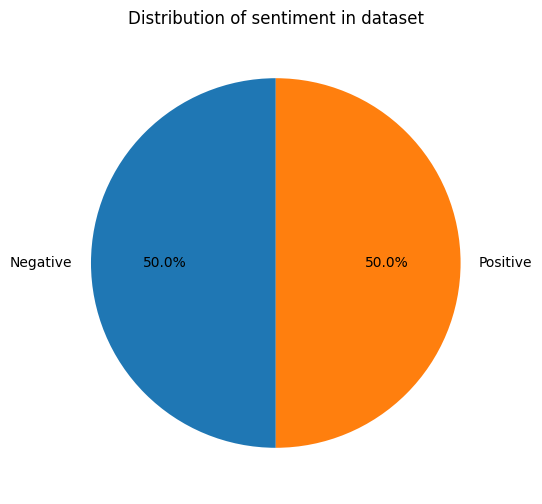

In [9]:

# Pie chart
# Count sentiment values, ensuring no NaNs or invalid entries
sentiment_counts = df_cleaned['sentiment'].value_counts()
labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'})

# Pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of sentiment in dataset')
plt.show()

As we can see there is a balance between positive and negative sentiment.

Cloudword for positive text


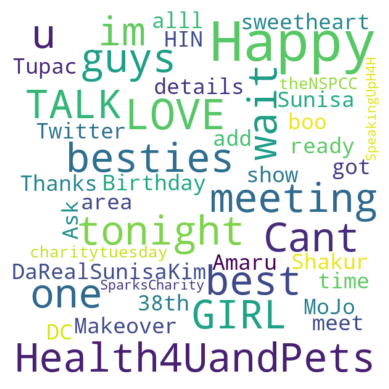

Cloudword for negative text


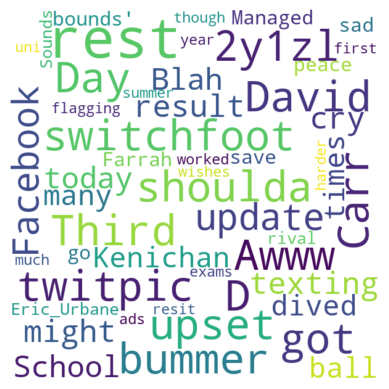

In [10]:
from wordcloud import STOPWORDS
text_positive = str(df_cleaned[df_cleaned['sentiment'] == 1]['text'].values)
text_negative = str(df_cleaned[df_cleaned['sentiment'] == 0]['text'].values)

def plot_word_cloud(text) :


    wc = WordCloud(width=600,height=600,background_color="white", max_words=200, stopwords=STOPWORDS,  max_font_size=90,collocations = False, random_state=42)

    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.show()

print("Cloudword for positive text")
plot_word_cloud(text_positive)
print("Cloudword for negative text")
plot_word_cloud(text_negative)

In [50]:
import re

def findLink(text):
    # Regular expression to find URLs
    urls = re.findall(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', text)
    return len(urls)  # Return the count of links found

def removeLink(text):
    return re.sub(r'http[s]?://\S+', '', text)  # Remove URLs from text

def findMail(text):
    # Regular expression to find email addresses
    emails = re.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', text)
    return len(emails)  # Return the count of emails found

def removeMail(text):
    return re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)  # Remove emails from text

def findQuote(text):
    # Count occurrences of quotes (single or double)
    quotes = re.findall(r'["\'].*?["\']', text)
    return len(quotes)  # Return the count of quotes found

def removeQuote(text):
    return re.sub(r'["\'].*?["\']', '', text)  # Remove quoted text from the string

def findHashtag(text):
    hashtags = re.findall(r'#\w+', text)
    return len(hashtags)  # Return the count of hashtags found

def replaceHashtag(text):
    return re.sub(r'#\w+', '', text)  # Remove hashtags from the string

def find_etc(text):
    etc_count = re.findall(r'\betc\.?\b', text, flags=re.IGNORECASE)
    return len(etc_count)  # Return the count of "etc." found

In [ ]:
df_cleaned

# Preprocessing

In [49]:
# Links
df_cleaned['links'] = df.text.apply(lambda x: findLink(x)) # on crée une colonne qui compte le nombre de lien par tweet
df_cleaned.text = df.text.apply(lambda x: removeLink(x))
# _Mails
df_cleaned['mails'] = df.text.apply(lambda x: findMail(x))
df_cleaned.text = df.text.apply(lambda x: removeMail(x))
# _Quotes
df_cleaned['quotes'] = df.text.apply(lambda x: findQuote(x))
df_cleaned.text = df.text.apply(lambda x: removeQuote(x))
# _Hastags
df_cleaned['hashtags'] = df.text.apply(lambda x: findHashtag(x))
df_cleaned.text = df.text.apply(lambda x: replaceHashtag(x))

df_cleaned['etc'] = df.text.apply(lambda x: find_etc(x))
df_cleaned['nb_caracter'] = df.text.apply(len)
df_cleaned.head()

C:\Users\dell\AppData\Local\Temp\ipykernel_17584\1872458255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['links'] = df.text.apply(lambda x: findLink(x)) # on crée une colonne qui compte le nombre de lien par tweet
C:\Users\dell\AppData\Local\Temp\ipykernel_17584\1872458255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.text = df.text.apply(lambda x: removeLink(x))
C:\Users\dell\AppData\Local\Temp\ipykernel_17584\1872458255.py:5: SettingWithCopyWarning: 
A value is trying to

,sentiment,text,links,mails,quotes,hashtags,etc,nb_caracter
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,0,0,0,0,115
1,0,is upset that he can't update his Facebook by ...,0,0,0,0,0,111
2,0,@Kenichan I dived many times for the ball. Man...,0,0,0,0,0,89
3,0,my whole body feels itchy and like its on fire,0,0,0,0,0,47
4,0,"@nationwideclass no, it's not behaving at all....",0,0,1,0,0,111


In [27]:
import re

# Définir une fonction de nettoyage complète
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
    # Remove @username
    text = re.sub(r'@\w+', '', text).strip()
    # Remove email addresses
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)
    # Remove quoted text
    text = re.sub(r'["\'].*?["\']', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove "etc."
    text = re.sub(r'\betc\.?\b', '', text, flags=re.IGNORECASE)
    return text

# Fonction pour extraire les métriques
def extract_features(text):
    return {
        'links': len(re.findall(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', text)),
        'emails': len(re.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', text)),
        'quotes': len(re.findall(r'["\'].*?["\']', text)),
        'hashtags': len(re.findall(r'#\w+', text)),
        'etc_count': len(re.findall(r'\betc\.?\b', text, flags=re.IGNORECASE)),
        'nb_caracter': len(text)
    }

# Appliquer aux données
df_cleaned['features'] = df_cleaned['text'].apply(extract_features)
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)

# Séparer les colonnes des features
features_df = pd.DataFrame(df_cleaned['features'].tolist())
df_cleaned = pd.concat([df_cleaned, features_df], axis=1)
df_cleaned = df_cleaned.drop('features', axis=1)


In [12]:
df_cleaned.head()

,sentiment,text,features,cleaned_text,links,emails,quotes,hashtags,etc_count,nb_caracter
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","{'links': 1, 'emails': 0, 'quotes': 0, 'hashta...","@switchfoot /2y1zl - Awww, that's a bummer. Y...",1,0,0,0,0,115
1,0,is upset that he can't update his Facebook by ...,"{'links': 0, 'emails': 0, 'quotes': 0, 'hashta...",is upset that he can't update his Facebook by ...,0,0,0,0,0,111
2,0,@Kenichan I dived many times for the ball. Man...,"{'links': 0, 'emails': 0, 'quotes': 0, 'hashta...",@Kenichan I dived many times for the ball. Man...,0,0,0,0,0,89
3,0,my whole body feels itchy and like its on fire,"{'links': 0, 'emails': 0, 'quotes': 0, 'hashta...",my whole body feels itchy and like its on fire,0,0,0,0,0,47
4,0,"@nationwideclass no, it's not behaving at all....","{'links': 0, 'emails': 0, 'quotes': 1, 'hashta...","@nationwideclass no, itm mad. why am i here? b...",0,0,1,0,0,111


In [31]:
for txt in df_cleaned.cleaned_text:
    txt = re.sub(r'@\w+', '', txt).strip()

0          /2y1zl - Awww, that's a bummer.  You shoulda g...
1          is upset that he can't update his Facebook by ...
2          I dived many times for the ball. Managed to sa...
3             my whole body feels itchy and like its on fire
4          no, itm mad. why am i here? because I can't se...
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999                                               happy 
Name: cleaned_text, Length: 1600000, dtype: object

In [34]:
df_cleaned.head()

,sentiment,text,cleaned_text,links,emails,quotes,hashtags,etc_count,nb_caracter,links,emails,quotes,hashtags,etc_count,nb_caracter
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","/2y1zl - Awww, that's a bummer. You shoulda g...",1,0,0,0,0,115,1,0,0,0,0,115
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,0,0,0,0,0,111,0,0,0,0,0,111
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to sa...,0,0,0,0,0,89,0,0,0,0,0,89
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0,0,0,0,0,47,0,0,0,0,0,47
4,0,"@nationwideclass no, it's not behaving at all....","no, itm mad. why am i here? because I can't se...",0,0,1,0,0,111,0,0,1,0,0,111


In [42]:
def Lemmatization(tweet):
    """Lemmatization of tweets"""
    processedText = []
    wordLemm = WordNetLemmatizer()

    for word in tweet.split():
        if len(word) > 1:
            # Lemmatizing the word.
            lemmatized_word = wordLemm.lemmatize(word)
            processedText.append(lemmatized_word)

    return ' '.join(processedText)  # Return as a single string

# Example usage
result = Lemmatization("this is a great day!")
print(result)

this is great day!
